In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

In [28]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((200, 600, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### Process content image to facilitate vgg16 prediction

In [29]:
image = cv2.imread("../data/base.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(600, 200))

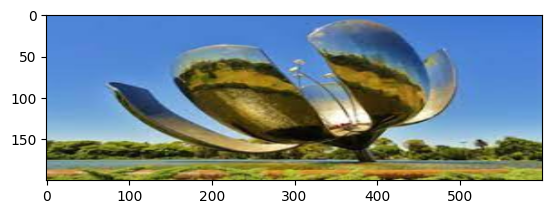

In [30]:
plt.imshow(image)

In [31]:
img_to_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

In [32]:
processed_image = tf.keras.applications.vgg16.preprocess_input(img_to_tensor)

In [33]:
pre_trained_model = vgg19.VGG19(weights="imagenet", include_top=False)

### Select layers used for content loss from pre trained model

In [34]:
for layer in pre_trained_model.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [35]:
content_layer = "block5_conv1"
content_model_output = Model(inputs = pre_trained_model.inputs, outputs = pre_trained_model.get_layer(content_layer).output)

In [36]:
content_model_output.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

### Create class inheriting from model class from keras. Easier for gpu use. 

In [37]:
class content_model(tf.keras.Model):       
    def __init__(self,content_model,shape):
        super().__init__()     
        self.pre_trained_model = content_model
        self.white_image = tf.Variable(tf.ones(shape = shape))       
    
    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
    
    def content_loss(self,image):    
        base_pred = self.pre_trained_model(image)     
        white_pred = self.pre_trained_model(self.white_image)         
        return tf.reduce_sum(tf.square(white_pred - base_pred))
        
    def train_step(self, data):            
        with tf.GradientTape() as tape:           
            loss = self.content_loss(data)     
        grads = tape.gradient(loss, [self.white_image])[0]         
        self.optimizer.apply_gradients([(grads, self.white_image)])  
        return {"loss": loss}

In [38]:
model = content_model(content_model_output,shape = (1,200,600,3))

In [39]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001))

### Original white image

In [40]:
white_image = deprocess_image(model.white_image[0].numpy())

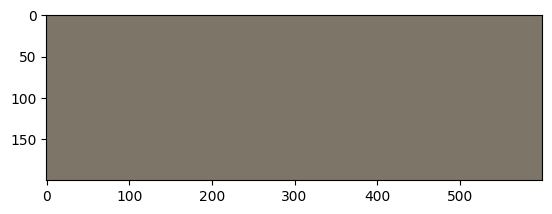

In [41]:
plt.imshow(white_image)

### Fitting

In [42]:
model.fit(x = np.expand_dims(processed_image,axis = 0),epochs = 4000)

Epoch 1/4000
1/1 [==============================] - 0s 456ms/step - loss: 2511101184.0000
Epoch 2/4000
1/1 [==============================] - 0s 34ms/step - loss: 2503630592.0000
Epoch 3/4000
1/1 [==============================] - 0s 36ms/step - loss: 2494217728.0000
Epoch 4/4000
1/1 [==============================] - 0s 36ms/step - loss: 2458275072.0000
Epoch 5/4000
1/1 [==============================] - 0s 34ms/step - loss: 2388661504.0000
Epoch 6/4000
1/1 [==============================] - 0s 32ms/step - loss: 2272049408.0000
Epoch 7/4000
1/1 [==============================] - 0s 30ms/step - loss: 2128643968.0000
Epoch 8/4000
1/1 [==============================] - 0s 31ms/step - loss: 1972284928.0000
Epoch 9/4000
1/1 [==============================] - 0s 30ms/step - loss: 1790227712.0000
Epoch 10/4000
1/1 [==============================] - 0s 29ms/step - loss: 1655385600.0000
Epoch 11/4000
1/1 [==============================] - 0s 31ms/step - loss: 1546584832.0000
Epoch 12/4000
1/1 

### Image after propagating gradient to pixels

In [43]:
result = deprocess_image(model.white_image[0].numpy())

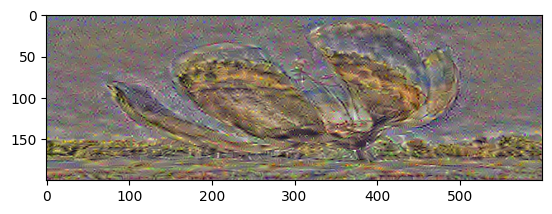

In [44]:
plt.imshow(result)